In [317]:
import cv2
import torch
import random
import copy
import time
import os

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from math import cos,sin,pi
from PIL import Image
from PIL import ImageChops
from collections import defaultdict


In [319]:
anno_file = '/Users/sty/DATA/wider_face_split/wider_face_train_bbx_gt.txt'
im_dir = '/Users/sty/DATA/WIDER_train/images'

pos_save_dir = './data_set/train/12/positive'
part_save_dir = './data_set/train/12/part'
neg_save_dir = './data_set/train/12/negative'

if not os.path.exists(pos_save_dir):
    os.makedirs(pos_save_dir)
if not os.path.exists(part_save_dir):
    os.mkdir(part_save_dir)
if not os.path.exists(neg_save_dir):
    os.mkdir(neg_save_dir)

f1 = open(os.path.join('./anno_store', 'pos_12.txt'), 'w')
f2 = open(os.path.join('./anno_store', 'neg_12.txt'), 'w')
f3 = open(os.path.join('./anno_store', 'part_12.txt'), 'w')

In [320]:
with open(anno_file) as f:
    annotations = f.readlines()
    
num = len(annotations)
print(num)

185184


In [321]:
p_idx = 0
n_idx = 0
d_idx = 0
idx = 0
box_idx = 0

In [322]:
n = -1
lines = []
for annotation in annotations:
    annotation = annotation.strip().split(' ')
    if annotation[0][-3:] == 'jpg':
        lines.append(annotation)
        n += 1
    else:
        annotation = list(map(int, annotation))
        lines[n].extend(annotation[:4])
len(lines)

12880

[5925, 11542]


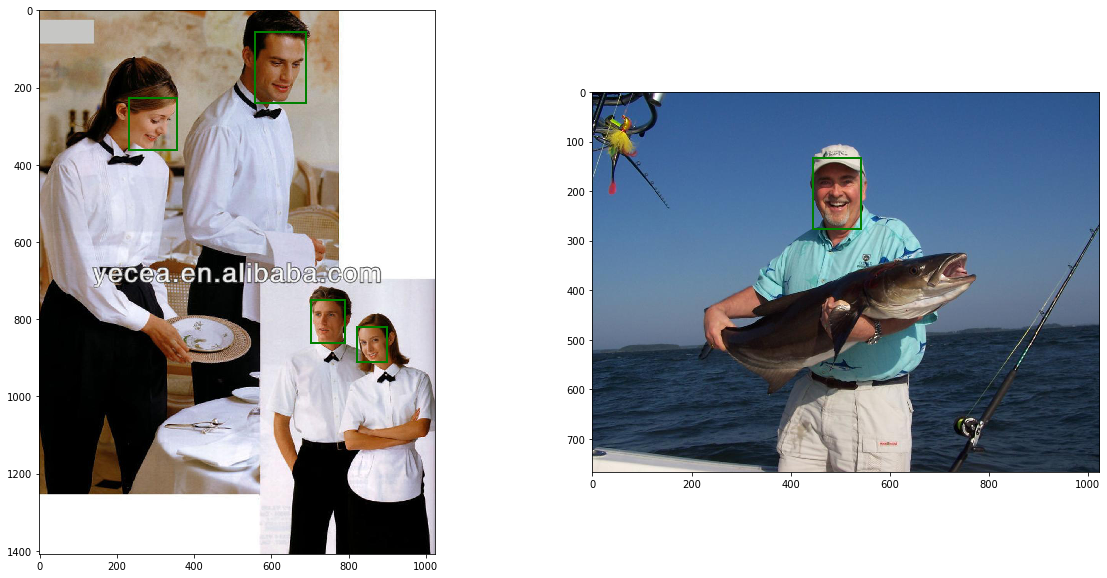

In [323]:
def my_show(lines,nums):
    lst = []
    fig, ax = plt.subplots(figsize=(20,10))
    for i in range(nums):
        n = random.randint(0,len(lines))
        lst.append(n)
        img = np.array(Image.open(os.path.join(im_dir,lines[n][0])))
        ax = plt.subplot(1, nums, i + 1)
        ax.imshow(img)
        
        loc = np.array(lines[n][2:]).reshape(-1, 4)
        for x1, y1, x2, y2 in loc:
            rect = plt.Rectangle((x1, y1), x2, y2, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
    print(lst)
        
        
my_show(lines, 2)


In [324]:
def IoU(box, boxes):
    
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = np.true_divide(inter,(box_area + area - inter))
    #ovr = inter / (box_area + area - inter)
    return ovr


In [325]:
for annotation in lines:
    im_path = os.path.join(im_dir, annotation[0])
    bbox = list(map(float, annotation[2:]))
    boxes = np.array(bbox, dtype=np.int32).reshape(-1, 4)
    boxes[:, 2] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 1]
    
    img = cv2.imread(im_path)
    idx += 1
    if idx % 100 == 0:
        print(idx, "images done")

    height, width, channel = img.shape

    neg_num = 0
    while neg_num < 50:
        size = np.random.randint(12, min(width, height) / 2)
        nx = np.random.randint(0, width - size)
        ny = np.random.randint(0, height - size)
        crop_box = np.array([nx, ny, nx + size, ny + size])

        Iou = IoU(crop_box, boxes)

        cropped_im = img[ny: ny + size, nx: nx + size, :]
        resized_im = cv2.resize(cropped_im, (12, 12), interpolation=cv2.INTER_LINEAR)

        if np.max(Iou) < 0.3:
            # Iou with all gts must below 0.3
            save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
            f2.write(save_file + ' 0\n')
            cv2.imwrite(save_file, resized_im)
            n_idx += 1
            neg_num += 1

    for box in boxes:
        # box (x_left, y_top, x_right, y_bottom)
        x1, y1, x2, y2 = box
        # w = x2 - x1 + 1
        # h = y2 - y1 + 1
        w = x2 - x1 + 1
        h = y2 - y1 + 1

        # ignore small faces
        # in case the ground truth boxes of small faces are not accurate
        if max(w, h) < 40 or x1 < 0 or y1 < 0:
            continue

        # generate negative examples that have overlap with gt
        for i in range(5):
            size = np.random.randint(12, min(width, height) / 2)
            # delta_x and delta_y are offsets of (x1, y1)

            delta_x = np.random.randint(max(-size, -x1), w)
            delta_y = np.random.randint(max(-size, -y1), h)
            nx1 = max(0, x1 + delta_x)
            ny1 = max(0, y1 + delta_y)

            if nx1 + size > width or ny1 + size > height:
                continue
            crop_box = np.array([nx1, ny1, nx1 + size, ny1 + size])
            Iou = IoU(crop_box, boxes)

            cropped_im = img[ny1: ny1 + size, nx1: nx1 + size, :]
            resized_im = cv2.resize(cropped_im, (12, 12), interpolation=cv2.INTER_LINEAR)

            if np.max(Iou) < 0.3:
                # Iou with all gts must below 0.3
                save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
                f2.write(save_file + ' 0\n')
                cv2.imwrite(save_file, resized_im)
                n_idx += 1

        # generate positive examples and part faces
        for i in range(20):
            size = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))

            # delta here is the offset of box center
            delta_x = np.random.randint(-w * 0.2, w * 0.2)
            delta_y = np.random.randint(-h * 0.2, h * 0.2)

            nx1 = max(x1 + w / 2 + delta_x - size / 2, 0)
            ny1 = max(y1 + h / 2 + delta_y - size / 2, 0)
            nx2 = nx1 + size
            ny2 = ny1 + size

            if nx2 > width or ny2 > height:
                continue
            crop_box = np.array([nx1, ny1, nx2, ny2])

            offset_x1 = (x1 - nx1) / float(size)
            offset_y1 = (y1 - ny1) / float(size)
            offset_x2 = (x2 - nx2) / float(size)
            offset_y2 = (y2 - ny2) / float(size)

            cropped_im = img[int(ny1): int(ny2), int(nx1): int(nx2), :]
            resized_im = cv2.resize(cropped_im, (12, 12), interpolation=cv2.INTER_LINEAR)

            box_ = box.reshape(1, -1)
            if IoU(crop_box, box_) >= 0.65:
                save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                p_idx += 1
            elif IoU(crop_box, box_) >= 0.4:
                save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                d_idx += 1
        box_idx += 1
        

f1.close()
f2.close()
f3.close()
print("%s images done, pos: %s part: %s neg: %s" % (idx, p_idx, d_idx, n_idx))


100 images done
200 images done
300 images done
400 images done
500 images done
600 images done
700 images done
800 images done
900 images done
1000 images done
1100 images done
1200 images done


KeyboardInterrupt: 

[301, 281, 428, 567]
size:525
delta_x:-41
delta_y:2
nx1: 211.5
ny1: 304.0


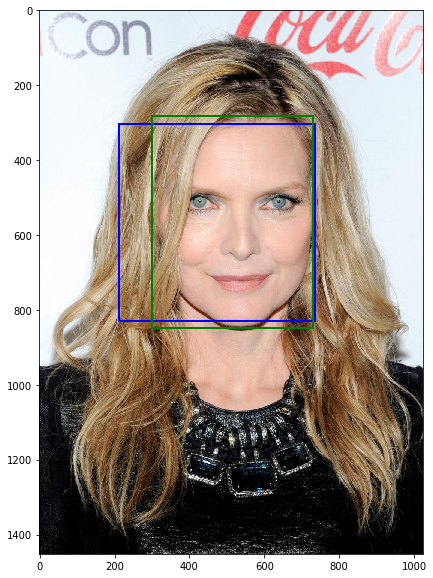

In [326]:
fig,ax = plt.subplots(figsize=(20, 10))
annotation = lines[2323]
im_path = os.path.join(im_dir, annotation[0])
bbox = list(map(float, annotation[2:]))
bboxes = np.array(bbox, dtype=np.int32).reshape(-1, 4)
x1, y1, w, h = bbox
print(list(map(int, bbox)))




size = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))
print(f'size:{size}')
            
delta_x = np.random.randint(-w * 0.2, w * 0.2)
delta_y = np.random.randint(-h * 0.2, h * 0.2)

print(f'delta_x:{delta_x}')
print(f'delta_y:{delta_y}')

nx1 = max(x1 + w / 2 + delta_x - size / 2, 0)
ny1 = max(y1 + h / 2 + delta_y - size / 2, 0)

print(f'nx1: {nx1}')
print(f'ny1: {ny1}')

crop_box = [nx1, ny1, size, size]


im_path = os.path.join(im_dir, annotation[0])
img = np.array(Image.open(im_path))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)
rect = plt.Rectangle((crop_box[0], crop_box[1]), crop_box[2], crop_box[3], linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)
for x1, y1, x2, y2 in bboxes:
    rect = plt.Rectangle((x1, y1), x2, y2, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

In [247]:
def s(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [331]:
w = torch.empty(3, 5)
a = nn.init.constant_(w, 0.3)
a

tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000]])

In [332]:
pnet_postive_file = './anno_store/pos_12.txt'
pnet_part_file = './anno_store/part_12.txt'
pnet_neg_file = './anno_store/neg_12.txt'
pnet_landmark_file = './anno_store/landmark_12.txt'
imglist_filename = './anno_store/imglist_anno_12.txt'

In [333]:
anno_list = []

anno_list.append(pnet_postive_file)
anno_list.append(pnet_part_file)
anno_list.append(pnet_neg_file)

In [335]:
import numpy.random as npr
import numpy as np

def assemble_data(output_file, anno_file_list=[]):
    if len(anno_file_list) == 0:
        return 0
    if os.path.exists(output_file):
        os.remove(output_file)
        
    for anno_file in anno_file_list:
        with open(anno_file, 'r') as f:
            print(anno_file)
            anno_lines = f.readlines()
        base_num = 2500000
        
        if len(anno_lines) > base_num * 3:
            idx_keep = npr.choice(len(anno_lines), size=base_num * 3, replace=True)
        elif len(anno_lines) > 100000:
            idx_keep = npr.choice(len(anno_lines), size=len(anno_lines), replace=True)
        else:
            idx_keep = np.arange(len(anno_lines))
            np.random.shuffle(idx_keep)
        
        chose_count = 0
        with open(output_file, 'a+') as f:
            for idx in idx_keep:
                f.write(anno_lines[idx])
                chose_count += 1
    
    return chose_count
            

In [336]:
chose_count = assemble_data(imglist_filename, anno_list)

./anno_store/pos_12.txt
./anno_store/part_12.txt
./anno_store/neg_12.txt


In [337]:
chose_count

80873

In [364]:
class ImageDB:
    def __init__(self, image_annotation_file, mode='train'):
        self.image_annotation_file = image_annotation_file
        self.classes = ['__background__', 'face']
        self.num_classes = 2
        self.image_set_index = self.load_image_set_index()
        self.num_images = len(self.image_set_index)
        self.mode = mode
    
    def load_image_set_index(self):
        with open(self.image_annotation_file, 'r') as f:
            image_set_index = [x.strip().split(' ')[0] for x in f.readlines()]
        return image_set_index
    
    def load_imdb(self):
        gt_imdb = self.load_annotations()
        return gt_imdb
    
    def real_image_path(self, index):
        pass
    
    def load_annotations(self, annotion_type=1):
        with open(self.image_annotation_file, 'r') as f:
            annotations = f.readlines()
    
        imdb = []
        for i in range(100):
            annotation = annotations[i].strip().split(' ')
            im_path = annotation[0]
            imdb_ = dict()
            imdb_['image'] = im_path
            
            if self.mode == 'test':
                pass
            else:
                label = annotation[1]
                imdb_['label'] = int(label)
                imdb_['flipped'] = False
                imdb_['bbox_target'] = np.zeros((4,))
                imdb_['landmark_target'] = np.zeros((10,))
                if len(annotation[2:]) == 4:
                    bbox_target = annotation[2: 6]
                    imdb_['bbox_target'] = np.array(bbox_target).astype(float)
                if len(annotation[2:]) == 14:
                    bbox_target = annotation[2: 6]
                    imdb_['bbox_target'] = np.array(bbox_target).astype(float)
                    landmark = annotation[6:]
                    imdb_['landmark_target'] = np.array(landmark).astype(float)
            imdb.append(imdb_)
        return imdb
    
    def append_flipped_image(self, imdb):
        print('append flipped images to imdb', len(imdb))
        
        for i in range(len(imdb)):
            imdb_ = imdb[i]
            m_bbox = imdb_['bbox_target'].copy()
            m_bbox[0], m_bbox[2] = -m_bbox[2], -m_bbox[0]
            
            landmark_ = imdb_['landmark_target'].copy()
            landmark_ = landmark_.reshape((5, 2))
            landmark_ = np.asarray([(1 - x, y) for (x, y) in landmark_])
            landmark_[[0, 1]] = landmark_[[1, 0]]
            landmark_[[3, 4]] = landmark_[[4, 3]]
            
            item = {'image': imdb_['image'],
                   'label': imdb_['label'],
                   'bbox_target': m_bbox,
                   'landmark_target': landmark_.reshape((10)),
                   'flipped': True}
            
            imdb.append(item)
        
        self.image_set_index *= 2
        return imdb

In [366]:
annotation_file = './anno_store/imglist_anno_12.txt'

imagedb = ImageDB(annotation_file)
gt_imdb = imagedb.load_imdb()
gt_imdb = imagedb.append_flipped_image(gt_imdb)
len(gt_imdb)

append flipped images to imdb 100


200